TODO:
* Interpolate back to model grid
* Further refinement of each mask level - different colours
* Describe number of points
* Refine bathy stuff - do separately

In [1]:
import os
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd

from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

import regridding

In [2]:
lon_min=-69
lon_max=-67
lat_min=48.25
lat_max=49.5

In [3]:
water = gpd.read_file('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/water.gpkg')
water = water.clip([lon_min, lat_min, lon_max, lat_max])

In [4]:
dciopse = xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/ciopse_mask_trex_250m.nc')
dciopse = dciopse.swap_dims({'X': 'lon', 'Y': 'lat'}).transpose('lat', 'lon')
dciopse_sel = dciopse.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
draster = xr.open_dataset('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/mask_trex_250m_from_raster.nc')
draster_sel = draster.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

In [5]:
ciopse_land = dciopse_sel.mask.data 
raster_land = np.nan_to_num(draster_sel.Band1.data) 

Raster has 3912 more ocean points that CIOPSE


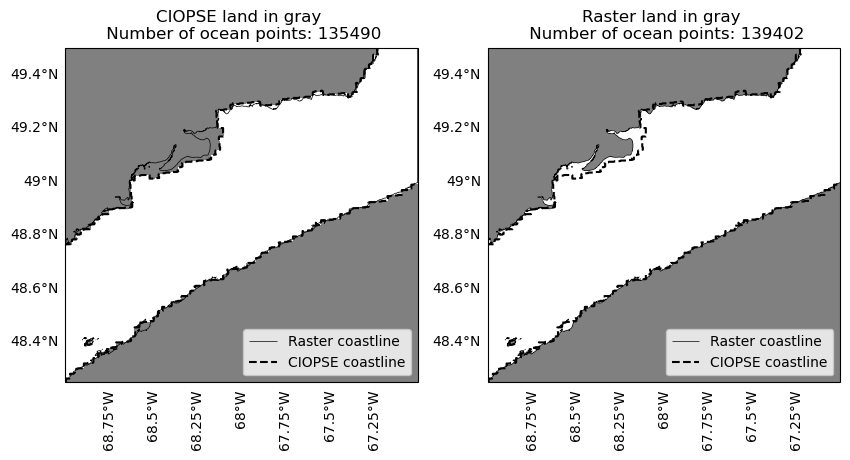

In [6]:
fig,axs = plt.subplots(1,2,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,10))
cmap_grey = ListedColormap([ "gray", "white"])

# CIOPSE
ax=axs[0]
ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.set_title(f'CIOPSE land in gray \n Number of ocean points: {np.sum(ciopse_land)}')
water.boundary.plot(color='k', lw=0.5, ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.contour(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', 'left',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')

# Raster
ax=axs[1]
ax.pcolormesh(draster_sel.lon, draster_sel.lat, raster_land,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.set_title(f'Raster land in gray \n Number of ocean points: {int(np.sum(raster_land))}')
water.boundary.plot(color='k', lw=0.5, ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.contour(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', 'left',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')
print(f'Raster has {int(np.sum(raster_land) - np.sum(ciopse_land)) } more ocean points that CIOPSE')

# Discrepancies between CIOPSE land and raster land

In [7]:
diff = ciopse_land - raster_land
discrepancies = (diff != 0)*1 # where ciopse_land and raster_land aren't equal
disc_ciopse_not_land = np.logical_and(discrepancies ,(ciopse_land!=0) ) #where ciopse_land and raster_land aren't equal and ciopse isn't land
disc_raster_not_land = np.logical_and(discrepancies ,(raster_land!=0) ) #where ciopse_land and raster_land aren't equal and raster isn't land

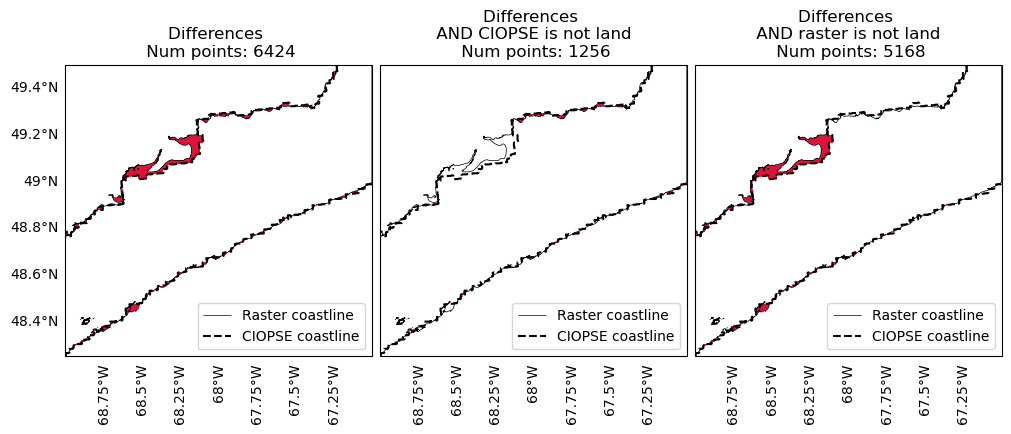

In [8]:
cmap_red = ListedColormap([ "white", "crimson"])
fig,axs = plt.subplots(1,3,subplot_kw={'projection':ccrs.PlateCarree()},
                       figsize=(10,10), sharey=True, constrained_layout=True)
ax=axs[0]
#ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,
#              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, discrepancies, cmap=cmap_red, transform=ccrs.PlateCarree())
water.boundary.plot(color='k', lw=0.5, ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.contour(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', 'left',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')
ax.set_title(f'Differences \n Num points: {np.sum(discrepancies)}')

ax=axs[1]
#ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,
#              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, disc_ciopse_not_land, cmap=cmap_red, transform=ccrs.PlateCarree())
ax.contour(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
water.boundary.plot(color='k', lw=0.5, ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', ],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')
ax.set_title(f"Differences \n AND CIOPSE is not land \n Num points: {np.sum(disc_ciopse_not_land)}")

ax=axs[2]
#ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,
#              transform=ccrs.PlateCarree(), cmap=cmap_grey)Disrepancies
ax.pcolormesh(dciopse_sel.lon, dciopse_sel.lat, disc_raster_not_land, cmap=cmap_red, transform=ccrs.PlateCarree())
water.boundary.plot(color='k', lw=0.5, ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.contour(dciopse_sel.lon, dciopse_sel.lat, ciopse_land,levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', ],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')
ax.set_title(f"Differences \n AND raster is not land \n Num points: {np.sum(disc_raster_not_land)}")

fig.savefig('STLE-250m-grid.png', bbox_inches='tight')

## Regridding to CIOPSE grid

In [9]:
ciopse_grid = xr.open_dataset('/home/soontiensn/data/gpsc-sdfo000/opp_drift_fa3/share_drift/CIOPSE_SN1500/CIOPSE_mesh_files/mesh_mask_NWA36_Bathymetry_flatbdy_20181109_3_filter_min_7p5.nc')
nav_lon = ciopse_grid.nav_lon.values
nav_lat = ciopse_grid.nav_lat.values
ciopse_grid_mask = ciopse_grid.tmask.values[0,0,:,:]

In [10]:
def regrid(array, lons, lats, newgrid,lon_var_name='nav_lon', lat_var_name='nav_lat', mask_name='mbathy'):

    new_mask = np.zeros_like(newgrid[mask_name].values[0,...])

    for j in range(len(lats)):
        lat = lats[j]
        if j % 50 == 0:
            print(f'{j}/{len(lats-1)}')
        for i in range(len(lons)):
            lon = lons[i]
            ix, iy, _, _ = regridding.find_containing_grid_cell(lon ,lat, newgrid, lon_var_name, lat_var_name)
            new_mask[iy, ix] +=array[j, i]
    return new_mask

In [11]:
fname = 'ciopse-mask_stlawrence.nc'
if not os.path.exists(fname):
    new_mask = regrid(discrepancies, dciopse_sel.lon.values, dciopse_sel.lat.values, ciopse_grid)
    dmask = xr.Dataset(data_vars=dict(mask=(['y', 'x'], new_mask),
                                  nav_lon=(['y','x'], nav_lon),
                                  nav_lat=(['y','x'], nav_lat)))
    dmask.to_netcdf(fname)
else:
    d = xr.open_dataset(fname)
    new_mask = d.mask.values

In [12]:
new_mask_mod = np.ma.masked_values(new_mask, 0)
new_mask_mod = (new_mask_mod >0) *1
new_mask_mod_ocean = np.logical_and(new_mask_mod, (ciopse_grid_mask ==1.0)) # where ciopse is ocean and there were disrepancies

In [13]:
# subsetting to region of interest
ixs = []
iys = []
ix, iy, _, _ = regridding.find_containing_grid_cell(lon_min ,lat_min, ciopse_grid, 'nav_lon', 'nav_lat')
ixs.extend(ix)
iys.extend(iy)
ix, iy, _, _ = regridding.find_containing_grid_cell(lon_min ,lat_max, ciopse_grid, 'nav_lon', 'nav_lat')
ixs.extend(ix)
iys.extend(iy)
ix, iy, _, _ = regridding.find_containing_grid_cell(lon_max ,lat_max, ciopse_grid, 'nav_lon', 'nav_lat')
ixs.extend(ix)
iys.extend(iy)
ix, iy, _, _ = regridding.find_containing_grid_cell(lon_max ,lat_min, ciopse_grid, 'nav_lon', 'nav_lat')
ixs.extend(ix)
iys.extend(iy)

iy_min = np.array(iys).min()
iy_max = np.array(iys).max()
ix_min = np.array(ixs).min()
ix_max = np.array(ixs).max()

ciopse_grid_sel = ciopse_grid.isel(x=slice(ix_min, ix_max), y=slice(iy_min, iy_max))
nav_lon_sel = ciopse_grid_sel.nav_lon.values
nav_lat_sel = ciopse_grid_sel.nav_lat.values
ciopse_grid_mask_sel = ciopse_grid_sel.tmask.values[0,0,:,:]

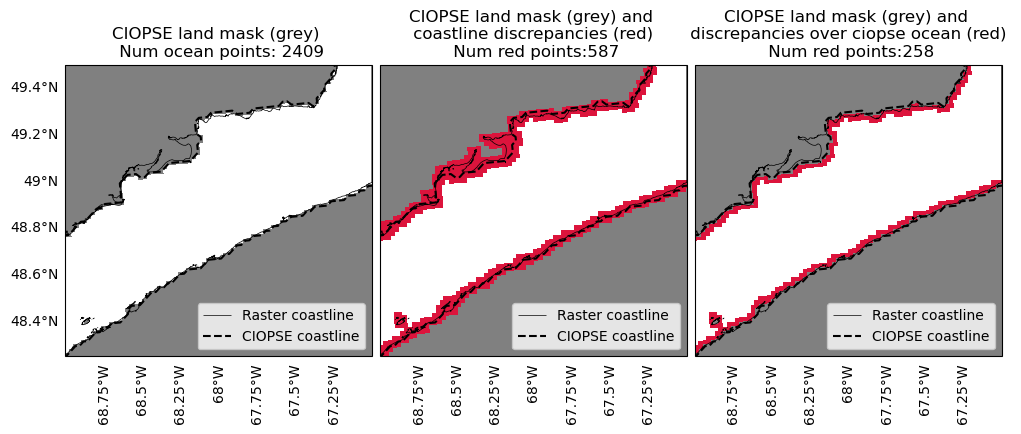

In [14]:
cmap_new = ListedColormap(["grey","crimson"])
cmap_other = ListedColormap(["crimson"])
fig,axs = plt.subplots(1,3,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,10),constrained_layout=True)
ax=axs[0]
ax.pcolormesh(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.contour(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel, levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_title(f'CIOPSE land mask (grey) \n Num ocean points: {np.nansum(ciopse_grid_mask_sel)}')
water.boundary.plot(color='k', lw=0.5,ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', 'left',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')

ax=axs[1]
ax.pcolormesh(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.pcolormesh(nav_lon, nav_lat, new_mask_mod,cmap=cmap_other,
              transform=ccrs.PlateCarree())
ax.contour(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel, levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_title(f'CIOPSE land mask (grey) and \n coastline discrepancies (red) \n Num red points:{np.nansum(new_mask_mod)}')
water.boundary.plot(color='k', lw=0.5,ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')

ax=axs[2]
ax.pcolormesh(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.pcolormesh(nav_lon, nav_lat, new_mask_mod_ocean,cmap=cmap_new,
              transform=ccrs.PlateCarree())
ax.contour(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel, levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
ax.set_title(f'CIOPSE land mask (grey) and \n discrepancies over ciopse ocean (red) \n Num red points:{np.nansum(new_mask_mod_ocean)}')
water.boundary.plot(color='k', lw=0.5,ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
handles.extend([line1])
ax.legend(handles=handles, loc='lower right')

fig.savefig('STLE-ciopse-original-grid.png', bbox_inches='tight')

Summary - in this proof of concept, we lost about 10% of of the CIOPSE ocean points.

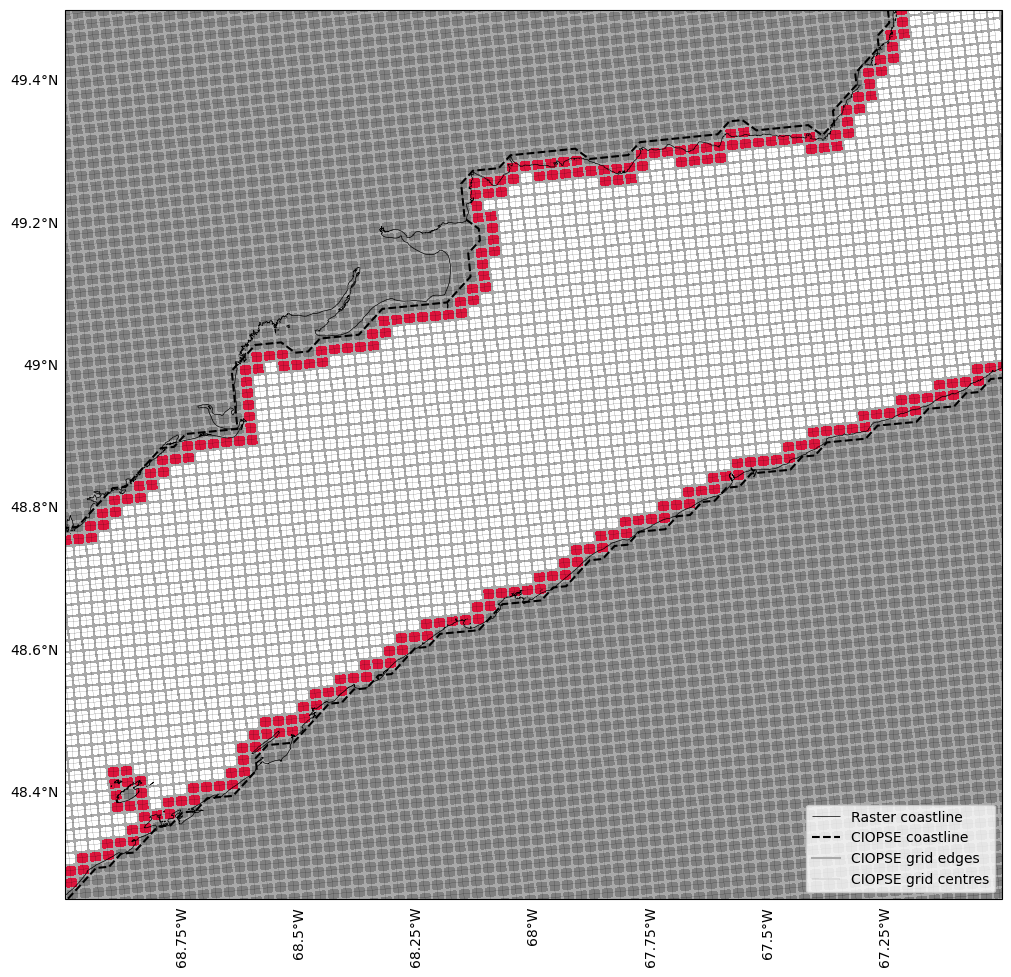

In [15]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,10),constrained_layout=True)
ax.pcolormesh(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel,
              transform=ccrs.PlateCarree(), cmap=cmap_grey)
ax.pcolormesh(nav_lon, nav_lat, new_mask_mod_ocean,cmap=cmap_new,edgecolors='darkgrey',
              transform=ccrs.PlateCarree())
ax.contour(nav_lon_sel, nav_lat_sel, ciopse_grid_mask_sel, levels=[0], colors='k',linestyles='--', transform=ccrs.PlateCarree())
water.boundary.plot(color='k', lw=0.5,ax=ax, transform=ccrs.PlateCarree(), label='Raster coastline')
for i in range(nav_lon_sel.shape[-1]):
    ax.plot(nav_lon_sel[:,i], nav_lat_sel[:,i],
              transform=ccrs.PlateCarree(), c='k',lw=0.1)
for j in range(nav_lon_sel.shape[0]):
    ax.plot(nav_lon_sel[j,:], nav_lat_sel[j,:],
              transform=ccrs.PlateCarree(), c='k',lw=0.1)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.gridlines(draw_labels=['bottom', 'left',],color='None', rotate_labels=True)
# Fake lagend
handles, labels = ax.get_legend_handles_labels()
line1 = Line2D([0], [0], label='CIOPSE coastline', color='k', ls='--')
line2 = Line2D([0], [0], label='CIOPSE grid edges', color='darkgrey')
line3 = Line2D([0], [0], label='CIOPSE grid centres', color='k', lw=0.1)
handles.extend([line1, line2, line3])
ax.legend(handles=handles, loc='lower right')

In [16]:
fig.savefig('STLE-ciopse-original-grid_withgridlines.png', bbox_inches='tight')